In [1]:
# -*- coding: utf-8 -*-
# 
#----------------------------------------------------------
# script name: 
#----------------------------------------------------------
# creator: zhidong.lu
# create date: 2019-05-30
# update date: 2021-08-21
# version: 1.0
#----------------------------------------------------------
# 
# 
#----------------------------------------------------------
import os
import re
import sys
import csv
import json
import time
import pytz
import datetime
strptime = datetime.datetime.strptime
strftime = datetime.datetime.strftime
from dateutil.relativedelta import relativedelta
from dateutil import rrule

from collections import OrderedDict
from itertools import product
import pickle

import gc
import multiprocessing

import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random

pd.pandas.set_option("display.max_columns", 100)
pd.pandas.set_option("display.max_rows", 300)

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# from xgboost.sklearn import XGBClassifier
# from xgboost import plot_tree
# from sklearn.ensemble import GradientBoostingClassifier

# pd.set_option('max_colwidth', 200)
# pd.set_option('display.max_rows', 40)
# pd.set_option('display.max_columns', None)

# import tensorflow as tf
# import tensorflow.keras as keras

# import lifelines
# from lifelines import KaplanMeierFitter
# from lifelines import CoxPHFitter
# from lifelines import CoxTimeVaryingFitter

import multiprocessing as mp

# import h5py


In [2]:
plt.style.use({"figure.figsize": [s0*3 for s0 in (5, 3)]})
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

sns.set(
    style="whitegrid",
    rc={"figure.figsize": [s0*3 for s0 in (5, 3)]},
    font="SimHei",
)

In [3]:
# 指定代码运行的绝对路径
path = r"/Users/luzhidong/Desktop/风控模型笔试题_20210823（反馈）"
output_path = r"{}/output_result_20210821".format(path)


In [4]:
# 
package_path = path
os.chdir(package_path)

from ModelingToolkit.LogisticModel import *
from ModelingToolkit.FeatureEngineering import *

# 题目一

In [5]:
df_problem_1 = pd.read_excel(
    "{}/题目一.xlsx".format(path),
    sheet_name="工作表1",
)[["gid", "raw1"]]

In [6]:
df_problem_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5462 entries, 0 to 5461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gid     5462 non-null   object
 1   raw1    5462 non-null   object
dtypes: object(2)
memory usage: 85.5+ KB


In [7]:
def _func(raw):
    _df = pd.DataFrame([
        json.loads(
            "{{{}}}".format(
                ",".join(
                    ['"{}":"{}"'.format(*t.split(":")) for t in _row.split(",")]
                )
            )
        )
        for _row in raw.split(";")
    ])
    
    rt = pd.Series(OrderedDict({
        "注册总次数": _df.shape[0],
        "注册总次数_非银行": _df.query("平台类型=='非银行'").shape[0],
        "注册最早时间": _df["注册时间"].min(),
        "注册平台数": _df["平台代码"].unique().shape[0],
        
    }))
    return rt

df_problem_1[["注册总次数", "注册总次数_非银行", "注册最早时间", "注册平台数"]] = \
    df_problem_1["raw1"].apply(_func)


## 输出结果

In [8]:
# df_problem_1.to_excel("{}/res_题目一.xlsx".format(output_path), index=False)

df_problem_1.head()


gid  \
0  fff834766f83b2e83da43edac2ec6e8e   
1  fff08a946b7460d1f7353bb2a5f3153f   
2  ffe54f2cb3b8e2c1ac20b45344149d68   
3  ffd62e39f01fa9d492dce8c26cea63a0   
4  ffc1d94876d9f006dc3f5dbfe6eac3aa   

                                                raw1  注册总次数  注册总次数_非银行  \
0       平台类型:非银行,平台代码:PAI_0000002823,注册时间:2016-07-28      1          1   
1  平台类型:非银行,平台代码:PAI_0000004232,注册时间:2017-04-19;平...      2          2   
2  平台类型:非银行,平台代码:PAI_0000182960,注册时间:2016-11-12;平...      2          2   
3       平台类型:非银行,平台代码:PAI_0000003890,注册时间:2017-06-26      1          1   
4       平台类型:非银行,平台代码:PAI_0000003890,注册时间:2017-05-27      1          1   

       注册最早时间  注册平台数  
0  2016-07-28      1  
1  2016-09-07      2  
2  2016-11-12      2  
3  2017-06-26      1  
4  2017-05-27      1

# 题目二

In [9]:
df_problem_2 = pd.read_excel(
    "{}/题目二.xlsx".format(path),
    sheet_name="内部日志详情",
)[["gid", "data1", "data2", "data3", "data4"]]

In [10]:
df_problem_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gid     1000 non-null   int64 
 1   data1   1000 non-null   object
 2   data2   1000 non-null   object
 3   data3   989 non-null    object
 4   data4   1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


In [11]:
def _func_json_trans(data_dict):
    
    _l = []
    for _k in data_dict.keys():
        _v = data_dict[_k]
        
        if not isinstance(_v, dict):
            _l.append(
                [
                    _k,
                    _v,
                ]
            )
        else:
            _l = _l+[
                [
                    "{}.{}".format(_k, _kk),
                    _vv,
                ]
                for _kk, _vv in _func_json_trans(_v).items()
            ]
    
    rt = dict(_l)
    return rt


## data1

In [12]:
# 查看结构
for s0 in df_problem_2["data1"].sample(1, random_state=9999):
    
    print("-"*100)
    print(json.dumps(json.loads(s0), indent=4))
    print()
    

----------------------------------------------------------------------------------------------------
{
    "code": "200",
    "data": {
        "ISPNUM": {
            "province": "\u7518\u8083",
            "city": "\u5170\u5dde",
            "isp": "\u79fb\u52a8"
        },
        "RSL": [
            {
                "RS": {
                    "code": "-9999",
                    "desc": "{\"GEO_SCORE\":\"394\",\"CDDT001\":\"5\",\"CDDT002\":\"4\",\"CDDT003\":\"22\",\"CDDT004\":\"22\",\"CDDT005\":\"18\",\"CDDT006\":\"18\",\"CDDT007\":\"3\",\"CDDT008\":\"2\",\"CDDT009\":\"2016-11-07\",\"CDDT010\":\"0.18181818181818182\",\"CDDT011\":\"-153\",\"CDDT012\":\"-153\",\"CDDT013\":\"-675\",\"CDDT014\":\"-675\",\"CDDT015\":\"-1\",\"CDDT016\":\"174.00000000000000\",\"CDDT017\":\"174.00000000000000\",\"CDDT018\":\"59.000000000000000\",\"CDDT019\":\"0.18181818181818182\",\"CDDT020\":\"0.21052631578947368\",\"CDDT021\":\"0.26315789473684211\",\"CDDT022\":\"3\",\"CDDT023\":\"-152\",\"CDDT024\":\

In [13]:
_df_p2_d1 = df_problem_2[["gid", "data1"]]

def _func(data_str):
    data_dict = json.loads(data_str)
    
    rt = pd.Series(OrderedDict(_func_json_trans(data_dict)))
    return rt

_df_p2_d1[["code", "data.ISPNUM.province", "data.ISPNUM.city", "data.ISPNUM.isp", "data.RSL", "data.ECL", "msg"]] = \
    _df_p2_d1["data1"].apply(lambda s0: _func(s0))


## 输出结果

In [14]:
# _df_p2_d1.to_excel("{}/res_题目二_data1.xlsx".format(output_path), index=False, sheet_name="data1")

_df_p2_d1.head()


gid                                              data1 code  \
0    1  {"code":"200","data":{"ISPNUM":{"province":"河北...  200   
1    2  {"code":"200","data":{"ISPNUM":{"province":"山东...  200   
2    3  {"code":"200","data":{"ISPNUM":{"province":"广东...  200   
3    4  {"code":"200","data":{"ISPNUM":{"province":"江苏...  200   
4    5  {"code":"200","data":{"ISPNUM":{"province":"贵州...  200   

  data.ISPNUM.province data.ISPNUM.city data.ISPNUM.isp  \
0                   河北               唐山              联通   
1                   山东               泰安              移动   
2                   广东               中山              移动   
3                   江苏               盐城              移动   
4                   贵州               毕节              电信   

                                            data.RSL data.ECL msg  
0  [{'RS': {'code': '-9999', 'desc': '{"GEO_SCORE...       []  成功  
1  [{'RS': {'code': '-9999', 'desc': '{"GEO_SCORE...       []  成功  
2  [{'RS': {'code': '-9999', 'desc': '{"GEO_SCORE...       []  成功  
3  [{'RS': {'code': '-9999', 'desc': '{"GEO_SCORE...       []  成功  
4  [{'RS': {'code': '-9999', 'desc': '{"GEO_SCORE...       []  成功

## data2

In [15]:
# 查看结构
for s0 in df_problem_2["data2"].sample(1, random_state=9999):
    
    print("-"*100)
    print(json.dumps([json.loads(t) for t in s0.split(";") if t!=""], indent=4))
    print()
    

----------------------------------------------------------------------------------------------------
[
    {
        "sign": "6B5C777A136FFE57CF407B1599AFB35A",
        "header": {
            "resp_time": "2018-09-13 13:32:05",
            "ret_msg": "\u64cd\u4f5c\u6210\u529f",
            "version": "4.1",
            "ret_code": "000000",
            "req_time": "2018-09-13 13:32:05"
        },
        "body": {
            "scores": {
                "MODEL7": "0.84726995",
                "MODEL5": "0.3440346",
                "MODEL6": "0.8464091",
                "MODEL3": "0.21445674",
                "MODEL4": "0.09289404",
                "MODEL1": "0.54777914",
                "MODEL2": "0.35865787"
            },
            "ud_order_no": "366099254227959810"
        }
    },
    {
        "CODE": "200",
        "PHONE": "15294111860",
        "PROVINCE": "\u7518\u8083",
        "CITY": "\u5170\u5dde",
        "RESULTS": [
            {
                "TYPE": "EMR002",
  

In [16]:
_df_p2_d2 = df_problem_2[["gid", "data2"]]

def _func(data_str):
    data_dict = dict([
        tuple(d)
        for d in np.concatenate(
            [list(json.loads(t).items()) for t in data_str.split(";") if t!=""]
        )
    ])
    
    rt = pd.Series(OrderedDict(_func_json_trans(data_dict)))
    return rt


_df_p2_d2[["header.resp_time", "header.ret_msg", "header.version", "header.ret_code", "header.req_time", "result.status", "result.score", "result.features", "result.cid", "code", "sign", "body.scores.MODEL7", "body.scores.MODEL5", "body.scores.MODEL6", "body.scores.MODEL3", "body.scores.MODEL4", "body.scores.MODEL1", "body.scores.MODEL2", "body.ud_order_no", "CODE", "PHONE", "PROVINCE", "CITY", "RESULTS", "result", "body.tags.tagList.gangListRules", "body.tags.tagMap.gang_type", "body.tags.tagMap.gang_no", "body.tags.tagList.deviceListRules", "body.tags.tagMap.gang_organize_ratio", "body.tags.tagList.nameListRules"]] = \
    _df_p2_d2["data2"].apply(lambda s0: _func(s0))



## 输出结果

In [17]:
# _df_p2_d2.to_excel("{}/res_题目二_data2.xlsx".format(output_path), index=False, sheet_name="data2")

_df_p2_d2.head()


gid                                              data2  \
0    1  {"header":{"resp_time":"2018-09-13 14:46:43","...   
1    2  {"sign":"EDA3FC8F44FA823D033E5D043D3BDEEF","he...   
2    3  {"header":{"resp_time":"2018-09-13 14:46:23","...   
3    4  {"sign":"9EF8730F5FE66A3E3692DAE3620AD2A0","he...   
4    5  {"header":{"resp_time":"2018-09-13 14:45:42","...   

      header.resp_time header.ret_msg header.version header.ret_code  \
0  2018-09-13 14:46:43     缺少足够信息进行评分            4.1          100051   
1  2018-09-13 14:46:24           操作成功            4.1          000000   
2  2018-09-13 14:46:23     缺少足够信息进行评分            4.1          100051   
3  2018-09-13 14:46:23           操作成功            4.1          000000   
4  2018-09-13 14:45:42     缺少足够信息进行评分            4.1          100051   

       header.req_time result.status result.score result.features  \
0  2018-09-13 14:46:43             0  0.125187842      eaaaodaaaa   
1  2018-09-13 14:46:24             0  0.137053964      aaaajaaaaa   
2  2018-09-13 14:46:23             0   0.16416944      aaaaaaaaaa   
3  2018-09-13 14:46:23           NaN          NaN             NaN   
4  2018-09-13 14:45:42           NaN          NaN             NaN   

           result.cid  code                              sign  \
0  130202198205223320  0000                               NaN   
1  370982197910275273  0000  EDA3FC8F44FA823D033E5D043D3BDEEF   
2  440921199503055761  0000                               NaN   
3                 NaN  0030  9EF8730F5FE66A3E3692DAE3620AD2A0   
4                 NaN  0030                               NaN   

  body.scores.MODEL7 body.scores.MODEL5 body.scores.MODEL6 body.scores.MODEL3  \
0                NaN                NaN                NaN                NaN   
1         0.84780574         0.19897029          0.8516686         0.08275862   
2                NaN                NaN                NaN                NaN   
3         0.85628027         0.50257796          0.8612694          0.4415579   
4                NaN                NaN                NaN                NaN   

  body.scores.MODEL4 body.scores.MODEL1 body.scores.MODEL2  \
0                NaN                NaN                NaN   
1        0.040860534         0.40016907         0.18164131   
2                NaN                NaN                NaN   
3         0.06654881         0.73813224         0.40582624   
4                NaN                NaN                NaN   

     body.ud_order_no CODE        PHONE PROVINCE CITY  \
0                 NaN  NaN          NaN      NaN  NaN   
1  366118405491130370  200  13665382633       山东   泰安   
2                 NaN  200  13549800559       广东   中山   
3  366118401192886275  200  18862052268       江苏   盐城   
4                 NaN  200  18076184927       贵州   毕节   

                                             RESULTS result  \
0                                                NaN    NaN   
1  [{'TYPE': 'EMR002', 'CYCLE': '2016-09-13--2018...    NaN   
2  [{'TYPE': 'EMR002', 'CYCLE': '2016-09-13--2018...    NaN   
3  [{'TYPE': 'EMR002', 'CYCLE': '2016-09-13--2018...    未命中   
4  [{'TYPE': 'EMR002', 'CYCLE': '2016-09-13--2018...    未命中   

  body.tags.tagList.gangListRules body.tags.tagMap.gang_type  \
0                             NaN                        NaN   
1                             NaN                        NaN   
2                             NaN                        NaN   
3                             NaN                        NaN   
4                             NaN                        NaN   

  body.tags.tagMap.gang_no body.tags.tagList.deviceListRules  \
0                      NaN                               NaN   
1                      NaN                               NaN   
2                      NaN                               NaN   
3                      NaN                               NaN   
4                      NaN                               NaN   

  body.tags.tagMap.gang_organize_ratio body.t

## data3

In [18]:
# 查看结构
for s0 in df_problem_2["data3"].sample(1, random_state=9999):
    
    print("-"*100)
    print(json.dumps([json.loads(t) for t in s0.split(";") if t!=""], indent=4))
    print()
    

----------------------------------------------------------------------------------------------------
[
    {
        "data": {
            "cg": 0.08887913823127747,
            "pr": "-",
            "ap": "-",
            "in": "-",
            "co": "-",
            "li": "-"
        },
        "errcode": 0,
        "errdetail": null,
        "errmsg": "OK",
        "ext": null
    },
    {
        "result": "\u672a\u547d\u4e2d",
        "code": "0030"
    }
]



In [19]:
_df_p2_d3 = df_problem_2[["gid", "data3"]]

def _func(data_str):
    data_dict = dict([
        tuple(d)
        for d in np.concatenate(
            [list(json.loads(t).items()) for t in data_str.split(";") if t!=""]
        )
    ])
    
    rt = pd.Series(OrderedDict(_func_json_trans(data_dict)))
    return rt


_df_p2_d3[["data.cg", "data.pr", "data.ap", "data.in", "data.co", "data.li", "errcode", "errdetail", "errmsg", "ext", "result.status", "result.score", "result.features", "result.cid", "code", "result"]] = \
    _df_p2_d3["data3"].fillna("{}").apply(lambda s0: _func(s0))



## 输出结果

In [20]:
# _df_p2_d3.to_excel("{}/res_题目二_data3.xlsx".format(output_path), index=False, sheet_name="data3")

_df_p2_d3.head()


gid                                              data3   data.cg data.pr  \
0    1  {"data":{"cg":0.3316981196403503,"pr":"-","ap"...  0.331698       -   
1    2  {"data":{"cg":0.6261994242668152,"pr":"-","ap"...  0.626199       -   
2    3  {"data":{"cg":0.225735142827034,"pr":"-","ap":...  0.225735       -   
3    4  {"data":{"cg":0.04545709490776062,"pr":"-","ap...  0.045457       -   
4    5  {"data":{"cg":0.2067922502756119,"pr":"-","ap"...  0.206792       -   

  data.ap data.in data.co data.li  errcode  errdetail errmsg  ext  \
0       -       -       -       -      0.0        NaN     OK  NaN   
1       -       -       -       -      0.0        NaN     OK  NaN   
2       -       -       -       -      0.0        NaN     OK  NaN   
3       -       -       -       -      0.0        NaN     OK  NaN   
4       -       -       -       -      0.0        NaN     OK  NaN   

  result.status result.score result.features          result.cid  code result  
0             0  0.864795635      aaaaeaeaaa  45080319820209757X  0000    NaN  
1             0   0.85035506      febfjajjjc  440112199203100612  0000    NaN  
2             0  0.863215438      aaaajajaaa  620421198207172519  0000    NaN  
3             0  0.900337363      ecaajajagi  612430199305040721  0000    NaN  
4             0  0.871532867      aaaajajaaa  360724198310236519  0000    NaN

## data4

In [21]:
# 查看结构
for s0 in df_problem_2["data4"].sample(1, random_state=9999):
    
    print("-"*100)
    print(json.dumps(json.loads(s0), indent=4))
    print()
    

----------------------------------------------------------------------------------------------------
{
    "meid": "",
    "city": "\u695a\u96c4",
    "modelId": "",
    "latitude": "",
    "isp": "\u79fb\u52a8",
    "regDate": "",
    "imsi": "",
    "idNumber": "530128199503060029",
    "cardNo": "",
    "entryId": "",
    "INDX304000": "{\"GEO_SCORE\":551,\"CDZC017\":\"\",\"CDZC007\":\"\",\"CDZC015\":\"\",\"CDZC016\":\"\",\"CDZC005\":\"\",\"CDZC013\":\"\",\"CDZC003\":\"\",\"CDZC014\":\"\",\"CDZC011\":\"\",\"CDZC012\":\"\"}",
    "sequenceNo": "263",
    "province": "\u4e91\u5357",
    "workAdress": "",
    "cid2": "",
    "company": "",
    "vin": "",
    "applyTime": "",
    "deadline": "",
    "longitude": "",
    "addressCode": "",
    "original_cid": "15911789659",
    "address": "",
    "dataType": "",
    "ip": "",
    "original_cid2": "",
    "homeAdress": "",
    "usualaddress": "",
    "realName": "\u674e\u7ea2\u743c",
    "platenumber": "",
    "platetype": "",
    "month"

In [22]:
_df_p2_d4 = df_problem_2[["gid", "data4"]]

def _func(data_str):
    data_dict = json.loads(data_str)
    try:
        data_dict["INDX304000"] = json.loads(data_dict["INDX304000"])
    except:
        data_dict["INDX304000"] = {"value": data_dict["INDX304000"]}
    
    rt = pd.Series(OrderedDict(_func_json_trans(data_dict)))
    return rt

_df_p2_d4[["meid", "city", "modelId", "latitude", "isp", "regDate", "imsi", "idNumber", "cardNo", "entryId", "INDX304000.GEO_SCORE", "INDX304000.CDZC017", "INDX304000.CDZC007", "INDX304000.CDZC015", "INDX304000.CDZC016", "INDX304000.CDZC005", "INDX304000.CDZC013", "INDX304000.CDZC003", "INDX304000.CDZC014", "INDX304000.CDZC011", "INDX304000.CDZC012", "sequenceNo", "province", "workAdress", "cid2", "company", "vin", "applyTime", "deadline", "longitude", "addressCode", "original_cid", "address", "dataType", "ip", "original_cid2", "homeAdress", "usualaddress", "realName", "platenumber", "platetype", "month", "cid", "INDX304000.value"]] = \
    _df_p2_d4["data4"].apply(lambda s0: _func(s0))


## 输出结果

In [23]:
# _df_p2_d4.to_excel("{}/res_题目二_data4.xlsx".format(output_path), index=False, sheet_name="data4")

_df_p2_d4.head()


gid                                              data4 meid city modelId  \
0    1  {"meid":"","city":"贵港","modelId":"","latitude"...        贵港           
1    2  {"meid":"","city":"广州","modelId":"","latitude"...        广州           
2    3  {"meid":"","city":"白银","modelId":"","latitude"...        白银           
3    4  {"meid":"","city":"安康","modelId":"","latitude"...        安康           
4    5  {"meid":"","city":"赣州","modelId":"","latitude"...        赣州           

  latitude isp regDate imsi            idNumber cardNo entryId  \
0           移动               45080319820209757X                  
1           联通               440112199203100612                  
2           移动               620421198207172519                  
3           电信               612430199305040721                  
4           电信               360724198310236519                  

   INDX304000.GEO_SCORE INDX304000.CDZC017 INDX304000.CDZC007  \
0                 467.0                  1                  1   
1                 452.0                  6                  6   
2                 486.0                  1                  1   
3                 594.0                  5                  1   
4                 504.0                  1                  1   

  INDX304000.CDZC015 INDX304000.CDZC016 INDX304000.CDZC005 INDX304000.CDZC013  \
0                  1                  1                  1                  1   
1                 10                 10                  3                  1   
2                  1                  1                  1                  1   
3                  1                  7                  9                  1   
4                  1                  1                  1                  1   

  INDX304000.CDZC003 INDX304000.CDZC014 INDX304000.CDZC011 INDX304000.CDZC012  \
0                  1                  5                  1                  5   
1                  2                 10                  5                 10   
2                  1                 10                  1                 10   
3                  1                 10                  3                 10   
4                  1                 10                  1                 10   

  sequenceNo province workAdress cid2 company vin applyTime deadline  \
0        720       广西                                                  
1        288       广东                                                  
2        719       甘肃                                                  
3        864       陕西                                                  
4       1008       江西                                                  

  longitude addressCode original_cid address dataType ip original_cid2  \
0                        15977580902                                     
1                        15622776783                                     
2                        15193027583                                     
3                        18091512070                                     
4                        18979710075                                     

  homeAdress usualaddress realName platenumber platetype month          cid  \
0                              李敬初                              15977580902   
1                              陈佳杰                              15622776783   
2                              李顺承                              15193027583   
3                              徐世敏                              18091512070   
4                              邱吉斌                              18979710075   

  INDX304000.value  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

# 题目三

In [24]:
df_problem_3 = pd.read_excel(
    "{}/题目三.xlsx".format(path),
    sheet_name="Sheet1",
)

In [25]:
df_problem_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5487 entries, 0 to 5486
Columns: 1766 entries, gid to x1763
dtypes: float64(1565), int64(1), object(200)
memory usage: 73.9+ MB


In [26]:
df_problem_3.sample(10, random_state=9999)

gid  apply_time  y   x1   x2          x3  \
2305  992c29c5902f39a0d1d9d175df9bc099  2017-10-23  0  NaN  NaN         NaN   
3476  621ab143bb8614618d51a6127eb942a0  2017-11-19  0  NaN  NaN         NaN   
3736  4521f1580c75f85d554a2ad7e2311994  2017-11-25  0  NaN  NaN         NaN   
4932  a432e456f3e61651d4f7599673185fa8  2017-11-09  1  1.0  1.0  2016-12-21   
4997  258a44cd390e8bbb279246407dca119a  2017-11-08  0  NaN  NaN         NaN   
1333  47a30330411d5ad2c08138689a6ac5f0  2017-09-07  0  NaN  NaN         NaN   
2977  cdf2b206502c00a0e6a151885d4c689d  2017-10-11  0  2.0  2.0  2016-11-24   
759   f8bcb2dadcbd19a277b92fbb377d1b73  2017-09-18  0  NaN  NaN         NaN   
406   11606383cae815fc2cb2fd9caad8081a  2017-09-24  1  NaN  NaN         NaN   
1227  b7c1e17c3083f9b44848d96c76b45a3a  2017-09-10  0  NaN  NaN         NaN   

              x4   x5   x6   x7          x8          x9  x10  x11  x12  \
2305         NaN  NaN  NaN  NaN         NaN         NaN  NaN  NaN  NaN   
3476         NaN  NaN  NaN  NaN         NaN         NaN  NaN  NaN  NaN   
3736         NaN  NaN  NaN  NaN         NaN         NaN  NaN  NaN  NaN   
4932  2016-12-21  0.2  NaN  NaN         NaN         NaN  NaN  1.0  1.0   
4997         NaN  NaN  NaN  NaN         NaN         NaN  NaN  NaN  NaN   
1333         NaN  NaN  NaN  NaN         NaN         NaN  NaN  NaN  NaN   
2977  2016-12-06  0.5  1.0  1.0  2016-11-24  2016-11-24  0.5  1.0  1.0   
759          NaN  NaN  NaN  NaN         NaN         NaN  NaN  NaN  NaN   
406          NaN  NaN  NaN  NaN         NaN         NaN  NaN  NaN  NaN   
1227         NaN  NaN  NaN  NaN         NaN         NaN  NaN  NaN  NaN   

             x13         x14  x15  x16  x17  x18  x19  x20  x21  x22  x23  \
2305         NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3476         NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3736         NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4932  2016-12-21  2016-12-21  0.2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4997         NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1333         NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2977  2016-12-06  2016-12-06  0.2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
759          NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
406          NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1227         NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

      x24  x25  x26  x27  x28  x29  x30  x31  x32  x33  x34  x35  x36  x37  \
2305  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3476  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3736  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4932  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4997  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1333  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2977  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
759   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
406   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1227  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

      x38  x39  x40  x41  x42  x43  x44  x45  x46  x47  x48  x49  x50  x51  \
2305  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3476  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3736  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4932  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4997  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1333  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2977  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
759   NaN  NaN  NaN

In [27]:
df_wb_0 = df_problem_3 \
    .sort_values(by=["gid"], ascending=[True]) \
    .reset_index(drop=True)

## 1.统计样本中各个特征变量的最大值、最小值、均值、分位数。可以用一个函数实现。

In [29]:
_cols_feature = [s0 for s0 in df_wb_0.columns if re.search("^x", s0)!=None]

In [30]:
df_t_describe_summary = func_dataframe_describe(
    in_df=df_wb_0,
    var_names=_cols_feature,
).reset_index(drop=False)

# df_t_describe_summary.to_clipboard(index=False)


In [31]:
# 离散型特征检查
_cols_feature_num = df_t_describe_summary.query("data_type=='Numerical'")["column_name"].tolist()
_cols_feature_cate = df_t_describe_summary.query("data_type=='Categorical'")["column_name"].tolist()

pd.Series(np.concatenate([df_wb_0[s0].dropna().tolist() for s0 in _cols_feature_cate])) \
    .apply(lambda s0: len(strftime(strptime(s0, "%Y-%m-%d"), "%Y-%m-%d"))) \
    .value_counts()

# 对于x1-x1763的特征变量中的离散型特征，发现都为日期格式的特征。
# 因此，将其进行与apply_time（申请日期）字段进行时间差的计算，构造新的特征
# 在后续分析过程中，使用新特征代替原有的特征信息


10    119316
dtype: int64

In [32]:
# 计算天数差（apply_time减时间字段）

_time = time.time()

for _col in _cols_feature_cate[:]:
    df_wb_0["{}_n".format(_col)] = df_wb_0.apply(
        lambda s0: (
            np.NaN
            if pd.isna(s0[_col]) else
            (strptime(s0["apply_time"], "%Y-%m-%d")-strptime(s0[_col], "%Y-%m-%d")).days
        ),
        axis=1,
    )

print(time.time()-_time)


119.19971585273743


In [33]:
_cols_feature_n_all = [s0 for s0 in df_wb_0.columns if re.search("^x", s0)!=None]
_cols_feature_n_modeling = [
    s0 for s0 in df_wb_0.columns
    if re.search("^x", s0)!=None and s0 not in _cols_feature_cate
]

In [34]:
# 对所有特征进行描述性统计分析
df_t_describe_summary = func_dataframe_describe(
    in_df=df_wb_0,
    var_names=_cols_feature,
).reset_index(drop=False)

# df_t_describe_summary.to_clipboard(index=False)


In [36]:
df_t_describe_summary.head()

column_name    data_type  count  count_missing  count_nomissing  \
0          x1    Numerical   5487           3985             1502   
1          x2    Numerical   5487           3985             1502   
2          x3  Categorical   5487           3985             1502   
3          x4  Categorical   5487           3985             1502   
4          x5    Numerical   5487           3985             1502   

   pct_missing  pct_nomissing  unique_count  unique_pct         min      mean  \
0     0.726262       0.273738            36    0.006561           1  3.400799   
1     0.726262       0.273738            17    0.003098           1  2.131824   
2     0.726262       0.273738           441    0.080372  2016-07-09       NaN   
3     0.726262       0.273738           439    0.080007  2016-07-10       NaN   
4     0.726262       0.273738             8    0.001458         0.2  1.377963   

          max  percentile_05  percentile_25  percentile_50  percentile_75  \
0          43            1.0            1.0            1.0            1.0   
1          16            1.0            1.0            1.0            1.0   
2  2017-11-19            NaN            NaN            NaN            NaN   
3  2017-11-21            NaN            NaN            NaN            NaN   
4          20            0.2            0.2            0.2            0.2   

   percentile_95                                         top5_value   entropy  \
0            1.0  {1.0: 752.0, 2.0: 273.0, 3.0: 129.0, 4.0: 79.0...  1.077397   
1            1.0  {1.0: 866.0, 2.0: 264.0, 3.0: 134.0, 4.0: 80.0...  0.973173   
2            NaN  {'2016-07-30': 15, '2016-09-04': 15, '2016-09-...  1.784709   
3            NaN  {'2017-09-14': 17, '2017-09-02': 14, '2017-08-...  1.783146   
4            0.2  {0.2: 711.0, 0.5: 263.0, 3.0: 251.0, 1.0: 163....  1.011543   

   entropy_ratio  
0       0.299794  
1       0.342208  
2       0.292620  
3       0.292582  
4       0.483832

## 2.统计每个申请月的bad人数、 good人数、总人数、 bad_rate 。

In [37]:
# 好坏标签的整体分布情况

print(df_wb_0["y"].value_counts(normalize=False, dropna=False).to_dict())
print(df_wb_0["y"].value_counts(normalize=True, dropna=False).to_dict())

df_wb_0["target_label"] = df_wb_0["y"].apply(lambda s0: ("1_bad" if s0==1 else "0_good"))
df_wb_0["apply_time_YM"] = df_wb_0["apply_time"].apply(lambda s0: s0[0:7])


df_wb_0 = df_wb_0[
    ["gid", "apply_time", "apply_time_YM", "target_label", "y"]+
    [s0 for s0 in df_wb_0.columns if s0 not in ["gid", "apply_time", "apply_time_YM", "target_label", "y"]]
].reset_index(drop=True)


{0: 4669, 1: 818}
{0: 0.850920357207946, 1: 0.14907964279205393}


In [81]:
_df_gb_apply_time_YM = func_woe_report_v1(
    in_var=df_wb_0["apply_time_YM"],
    in_target=df_wb_0["target_label"],
    with_total=True,
)
_df_gb_apply_time_YM

0_good_#  1_bad_#  0_good_%   1_bad_%       WOE        IV  total  \
2017-08        24       14  0.005140  0.017115  1.189400  0.014243     38   
2017-09      1397      264  0.299208  0.322738  0.075680  0.001781   1661   
2017-10      1418      261  0.303705  0.319071  0.049340  0.000758   1679   
2017-11      1830      279  0.391947  0.341076 -0.138984  0.007070   2109   
total        4669      818  1.000000  1.000000       NaN  0.023852   5487   

         total_pct  bad_rate  
2017-08   0.006925  0.368421  
2017-09   0.302716  0.158940  
2017-10   0.305996  0.155450  
2017-11   0.384363  0.132290  
total     1.000000  0.149080

### 划分模型开发的样本集合
### 考虑到数据样本主要集中在2017-09到2017-11三个月份的数据，而且各月份进件分布比较均匀，因此考虑将2017-11的申请样本作为oot样本，对整体模型进行跨期校验
### 对于2017-08、2017-09、2017-10这部分的样本，作为开发样本，并且按60:40的比例，划分训练集（train）与测试集（test）

In [40]:
##########################################################################################
# random_seed = random.randint(1, 100000)
random_seed = 26272627

########################################
_df_oot = pd.concat([
    df_wb_0[["gid", "apply_time", "apply_time_YM"]].query("apply_time_YM=='2017-11'"),
], ignore_index=True) \
    .reset_index(drop=True)
_df_oot["_oot_flag"] = 1

########################################
_df = pd.merge(
    left=df_wb_0[["gid"]],
    right=_df_oot,
    how="left", left_on=["gid"], right_on=["gid"],
)
_df["data_role"] = ""
_df.loc[_df["_oot_flag"]==1, "data_role"] = "03_oot"


########################################
_df_train_idx, _df_test_idx = train_test_split(
    _df.query("data_role!='03_oot'")[["gid"]],
    train_size=0.6,
    random_state=random_seed,
)
_df.loc[_df_train_idx.index, "data_role"] = "01_train"
_df.loc[_df_test_idx.index, "data_role"] = "02_test"

################################################################################
df_wb_0 = pd.merge(
    left=_df[["data_role", "gid"]],
    right=df_wb_0,
    how="left", left_on=["gid"], right_on=["gid"],
) \
    .sort_values(by=["gid"], ascending=[True]) \
    .reset_index(drop=True)


print(df_wb_0.shape)


(5487, 1967)


In [41]:
_df = df_wb_0[["data_role", "y"]].groupby(by=["data_role"]).apply(
    lambda s0: pd.Series(OrderedDict({
        "cnt": s0.shape[0],
        "bad_cnt": s0.query("y==1").shape[0],
        "bad_rate": s0.query("y==1").shape[0]/s0.shape[0],
    }))
).sort_index(ascending=True)

_df.to_clipboard()
_df


cnt  bad_cnt  bad_rate
data_role                           
01_train   2026.0    325.0  0.160415
02_test    1352.0    214.0  0.158284
03_oot     2109.0    279.0  0.132290

## 3.对数值型数据，进行等频、等宽分箱。并统计每个变量分箱后每个箱子里的bad人数、good人数、总人数、bad人数占比，good人数占比，累计bad人数占比，累计good人数占比，总人数占比，bad_rate、woe、KS、IV

### 自动分箱处理（等频10等份）

In [42]:
###########################################################################
# 计算变量自动分箱后WOE、IV（fine binning）
def _func_calc_fine_iv(date_type, in_df, var_name, target_label):
    rt = OrderedDict({
        "crosstab_converted": None,
        "fine_IV": None,
        "boundary": None,
        "mapping_gb_class": None,
    })
    if date_type=="Numerical":
        _, rt["crosstab_converted"], rt["boundary"] = func_auto_binning_continuous_v2(
            in_df=in_df, var_name=var_name, target_label=target_label,
            min_pct=0.05-0.0001, max_bins_cnt=10,
            # min_pct=0.1-0.0001, max_bins_cnt=9,
            method="01_equal_freq",
            # method="02_decision_tree",
            # method="03_best_ks",
            with_lift_ks=True, lift_calc_ascending=True,
        )
    elif date_type=="Categorical":
        _, rt["crosstab_converted"], rt["mapping_gb_class"] = func_auto_combining_discrete_v2(
            in_df=in_df, var_name=var_name, target_label=target_label,
            min_pct=0.05-0.0001, max_bins_cnt=5,
            # method="01_equal_freq",
            method="02_best_ks",
            with_lift_ks=True, lift_calc_ascending=True,
        )
    _crosstab_converted = rt["crosstab_converted"]
    rt["fine_IV"] = _crosstab_converted.loc["total", "IV"]
    _d = _crosstab_converted["WOE"].reset_index(drop=True).dropna().reset_index().values
    _X = _d[:, 0]
    _y = _d[:, 1]
    return rt

df_t_features_fine_iv = df_t_describe_summary \
    [df_t_describe_summary["column_name"].isin(_cols_feature_num[:])] \
    [["column_name", "data_type"]].reset_index(drop=True)

##########################################################################
_time = time.time()

_fine_binning_result = []
for _column_name, _data_type in df_t_features_fine_iv.values:
    _fine_binning_result.append(
        _func_calc_fine_iv(
            date_type=_data_type,
            in_df=df_wb_0.query("data_role in ['01_train', '02_test']"),
            var_name=_column_name, target_label="target_label",
        )
    )
print("cost time: {} sec.".format(time.time()-_time))

df_t_features_fine_iv["fine_IV"] = [s0["fine_IV"] for s0 in _fine_binning_result]
# df_t_features_fine_iv["boundary"] = [([-np.inf, np.inf] if s0["boundary"]==None else [round(t, 4) for t in s0["boundary"]]) for s0 in _fine_binning_result]
df_t_features_fine_iv["boundary"] = [([round(t, 4) for t in s0["boundary"]] if s0["boundary"]!=None else None) for s0 in _fine_binning_result]
df_t_features_fine_iv["mapping_gb_class"] = [s0["mapping_gb_class"] for s0 in _fine_binning_result]
df_t_features_fine_iv["crosstab_converted"] = [s0["crosstab_converted"] for s0 in _fine_binning_result]
df_t_features_fine_iv["bin_cnt"] = df_t_features_fine_iv["crosstab_converted"].apply(lambda s0: s0[s0.index!="total"].shape[0])

df_t_features_fine_iv = df_t_features_fine_iv.sort_values(by=["fine_IV"], ascending=False).reset_index(drop=True)
# df_t_features_fine_iv.drop(labels=["crosstab_converted"], axis=1).to_clipboard(index=False)


cost time: 150.6486518383026 sec.


In [43]:
###########################################################################
# 计算开发样本的WOE报告
_t_features_fine_woe_report = []
for _column_name, _data_type, _crosstab_converted, _boundary, _mapping_gb_class in \
            df_t_features_fine_iv[["column_name", "data_type", "crosstab_converted", "boundary", "mapping_gb_class"]].values[:]:
    _crosstab_converted = _crosstab_converted.reset_index().rename(columns={"index": "gb_idx"}).query("gb_idx!='total'")
    _crosstab_converted.insert(loc=_crosstab_converted.columns.tolist().index("gb_idx"), column="feature_name", value=_column_name)
    if _data_type=="Categorical":
        _mapping_gb_label = dict(
            pd.Series(_mapping_gb_class).reset_index().rename(columns={"index": "value_label", 0: "gb_idx"}) \
                .groupby(by=["gb_idx"])["value_label"].apply(lambda s0: "/".join(s0.sort_values(ascending=True).tolist()))
        )
        _data_label = _crosstab_converted["gb_idx"].apply(lambda s0: _mapping_gb_label.get(s0, ""))
    elif _data_type=="Numerical":
        _data_label = _crosstab_converted["gb_idx"].apply(lambda s0: (s0.split("_")[-1] if s0!="total" else ""))
    _crosstab_converted.insert(loc=_crosstab_converted.columns.tolist().index("gb_idx")+1, column="label", value=_data_label)
    _t_features_fine_woe_report.append(_crosstab_converted)
df_t_features_fine_woe_report = pd.concat(_t_features_fine_woe_report, ignore_index=True).reset_index(drop=True)

# df_t_features_fine_woe_report.to_clipboard(index=False)


In [44]:
df_t_features_fine_iv_eq10 = df_t_features_fine_iv.reset_index(drop=True)
df_t_features_fine_woe_report_eq10 = df_t_features_fine_woe_report.reset_index(drop=True)

# df_t_features_fine_iv_eq10.drop(labels=["crosstab_converted"], axis=1).to_clipboard(index=False)
# df_t_features_fine_woe_report_eq10.to_clipboard(index=False)


### 自动分箱处理（等距5等份）

In [45]:
###########################################################################
# 计算变量自动分箱后WOE、IV（fine binning）
def _func_calc_fine_iv(date_type, boundary, in_df, var_name, target_label):
    rt = OrderedDict({
        "crosstab_converted": None,
        "fine_IV": None,
        "boundary": None,
        "mapping_gb_class": None,
    })
    if date_type=="Numerical":
        rt["crosstab_converted"] = func_woe_report_v1(
            in_var=func_binning_continuous_v1(
                in_data=in_df[var_name],
                bins=boundary,
                right_border=True,
                include_lowest=False,
            ),
            in_target=in_df[target_label],
            with_total=True,
            with_lift_ks=True, lift_calc_ascending=True,
        )
        rt["boundary"] = boundary
    elif date_type=="Categorical":
        _, rt["crosstab_converted"], rt["mapping_gb_class"] = func_auto_combining_discrete_v2(
            in_df=in_df, var_name=var_name, target_label=target_label,
            min_pct=0.05-0.0001, max_bins_cnt=5,
            # method="01_equal_freq",
            method="02_best_ks",
            with_lift_ks=True, lift_calc_ascending=True,
        )
    _crosstab_converted = rt["crosstab_converted"]
    rt["fine_IV"] = _crosstab_converted.loc["total", "IV"]
    _d = _crosstab_converted["WOE"].reset_index(drop=True).dropna().reset_index().values
    _X = _d[:, 0]
    _y = _d[:, 1]
    return rt

df_t_features_fine_iv = df_t_describe_summary \
    [df_t_describe_summary["column_name"].isin(_cols_feature_num[:])] \
    [["column_name", "data_type", "min", "max"]].reset_index(drop=True)

df_t_features_fine_iv["_bin"] = df_t_features_fine_iv.apply(
    lambda s0: [-np.inf]+pd.Series(np.unique([1+(s0["max"]-s0["min"])/5*(t) for t in range(5+1)])).sort_values().tolist()+[np.inf],
    axis=1,
)

##########################################################################
_time = time.time()

_fine_binning_result = []
for _column_name, _data_type, _, _, _bin in df_t_features_fine_iv.values:
    _fine_binning_result.append(
        _func_calc_fine_iv(
            date_type=_data_type,
            boundary=_bin,
            in_df=df_wb_0.query("data_role in ['01_train', '02_test']"),
            var_name=_column_name, target_label="target_label",
        )
    )
print("cost time: {} sec.".format(time.time()-_time))

df_t_features_fine_iv = df_t_features_fine_iv \
    .drop(labels=["min", "max", "_bin"], axis=1) \
    .reset_index(drop=True)

df_t_features_fine_iv["fine_IV"] = [s0["fine_IV"] for s0 in _fine_binning_result]
# df_t_features_fine_iv["boundary"] = [([-np.inf, np.inf] if s0["boundary"]==None else [round(t, 4) for t in s0["boundary"]]) for s0 in _fine_binning_result]
df_t_features_fine_iv["boundary"] = [([round(t, 4) for t in s0["boundary"]] if s0["boundary"]!=None else None) for s0 in _fine_binning_result]
df_t_features_fine_iv["mapping_gb_class"] = [s0["mapping_gb_class"] for s0 in _fine_binning_result]
df_t_features_fine_iv["crosstab_converted"] = [s0["crosstab_converted"] for s0 in _fine_binning_result]
df_t_features_fine_iv["bin_cnt"] = df_t_features_fine_iv["crosstab_converted"].apply(lambda s0: s0[s0.index!="total"].shape[0])

df_t_features_fine_iv = df_t_features_fine_iv.sort_values(by=["fine_IV"], ascending=False).reset_index(drop=True)
# df_t_features_fine_iv.drop(labels=["crosstab_converted"], axis=1).to_clipboard(index=False)


cost time: 141.9227192401886 sec.


In [46]:
###########################################################################
# 计算开发样本的WOE报告
_t_features_fine_woe_report = []
for _column_name, _data_type, _crosstab_converted, _boundary, _mapping_gb_class in \
            df_t_features_fine_iv[["column_name", "data_type", "crosstab_converted", "boundary", "mapping_gb_class"]].values[:]:
    _crosstab_converted = _crosstab_converted.reset_index().rename(columns={"index": "gb_idx"}).query("gb_idx!='total'")
    _crosstab_converted.insert(loc=_crosstab_converted.columns.tolist().index("gb_idx"), column="feature_name", value=_column_name)
    if _data_type=="Categorical":
        _mapping_gb_label = dict(
            pd.Series(_mapping_gb_class).reset_index().rename(columns={"index": "value_label", 0: "gb_idx"}) \
                .groupby(by=["gb_idx"])["value_label"].apply(lambda s0: "/".join(s0.sort_values(ascending=True).tolist()))
        )
        _data_label = _crosstab_converted["gb_idx"].apply(lambda s0: _mapping_gb_label.get(s0, ""))
    elif _data_type=="Numerical":
        _data_label = _crosstab_converted["gb_idx"].apply(lambda s0: (s0.split("_")[-1] if s0!="total" else ""))
    _crosstab_converted.insert(loc=_crosstab_converted.columns.tolist().index("gb_idx")+1, column="label", value=_data_label)
    _t_features_fine_woe_report.append(_crosstab_converted)
df_t_features_fine_woe_report = pd.concat(_t_features_fine_woe_report, ignore_index=True).reset_index(drop=True)

# df_t_features_fine_woe_report.to_clipboard(index=False)


In [47]:
df_t_features_fine_iv_ew05 = df_t_features_fine_iv.reset_index(drop=True)
df_t_features_fine_woe_report_ew05 = df_t_features_fine_woe_report.reset_index(drop=True)

# df_t_features_fine_iv_ew05.drop(labels=["crosstab_converted"], axis=1).to_clipboard(index=False)
# df_t_features_fine_woe_report_ew05.to_clipboard(index=False)


## 4.划分训练测试集建立风险预测模型以便于识别好坏人，给出最终建立模型训练集和测试集的KS、AUC。建模方法（评分卡、XGBoost、神经网络）。


### 筛选确实率大于90%的特征变量

In [49]:
_df_exclude_01_missing = df_t_describe_summary[["column_name", "pct_missing"]] \
    .query("pct_missing>0.9")


In [50]:
_cols_modeling_keep_1 = [
    s0 for s0 in _cols_feature_num
    if s0 not in _df_exclude_01_missing["column_name"].tolist()
]
print(len(_cols_modeling_keep_1))


462


### 筛选细分箱IV值小于0.1（等频、等距两种分箱方法同时小于）

In [51]:
_df_exclude_02_fine_IV = pd.merge(
    left=df_t_features_fine_iv_eq10[["column_name", "fine_IV"]] \
        .query("fine_IV<0.1").rename(columns={"fine_IV": "fine_IV_eq10"}),
    right=df_t_features_fine_iv_ew05[["column_name", "fine_IV"]] \
        .query("fine_IV<0.1").rename(columns={"fine_IV": "fine_IV_ew05"}),
    how="inner", left_on=["column_name"], right_on=["column_name"],
)

In [52]:
_cols_modeling_keep_2 = [
    s0 for s0 in _cols_feature_num
    if (
        s0 not in _df_exclude_01_missing["column_name"].tolist() and
        s0 not in _df_exclude_02_fine_IV["column_name"].tolist()
    )
]
print(len(_cols_modeling_keep_2))


416


### 筛选单调性判断，保留严格单调特征

In [53]:
######################################################################################################
def _func_calc_binning_woe_stats_compare(in_df, var_name, target_label, compare_bin_cnt):
    _result = []
    for _max_bins_cnt in compare_bin_cnt[:]:
        _, _crosstab, _bin = func_auto_binning_continuous_v1(
            in_var=in_df[var_name],
            in_target=in_df[target_label],
            min_pct=0.05, max_bins_cnt=_max_bins_cnt,
            right_border=True, include_lowest=True,
        #     method="02_decision_tree",
            method="01_equal_freq",
            with_lift_ks=True, lift_calc_ascending=True,
        )
        _res = func_calc_binning_woe_stats(
            in_crosstab=_crosstab,
            plot=False,
        )
        _res = OrderedDict(
            [
                ("var_name", var_name),
                ("max_bins_cnt", _max_bins_cnt),
                ("bin", _bin),
            ]+
            list(_res.to_dict(into=OrderedDict).items())
        )
        _result.append(_res)
    
    rt = pd.DataFrame(_result)
    return rt


_time = time.time()
df_eq_binning_compare_result = []
for _idx, _col in enumerate(_cols_modeling_keep_2[:]):
    
#     print("{:.2%}, {}".format(_idx/len(_cols_modeling_keep_2[:]), time.time()-_time))
    _time = time.time()
    
    _df_eq_binning_compare_result = _func_calc_binning_woe_stats_compare(
        in_df=df_wb_0.query("data_role in ['01_train', '02_test']"),
        var_name=_col,
        target_label="target_label",
        compare_bin_cnt=[10, 6, 5, 4, 3],
    )
    df_eq_binning_compare_result.append(_df_eq_binning_compare_result)

df_eq_binning_compare_result = pd.concat(df_eq_binning_compare_result, ignore_index=True) \
    .reset_index(drop=True)


####################################################################################
_df_eq_binning_compare_result_n = []

######################################################
_df = df_eq_binning_compare_result \
    .sort_values(by=["var_name", "binning_cnt_notna", "totoal_pct_cv"], ascending=[True, True, True]) \
    .drop_duplicates(subset=["var_name", "binning_cnt_notna"]) \
    [df_eq_binning_compare_result["corr_kendall"].apply(lambda s0: round(s0, 2) in [-1, 1])] \
    .query("binning_cnt_notna>=3 and binning_cnt_notna<=6") \
    .sort_values(by=["var_name", "IV_pre_bin_notna", "binning_cnt_notna"], ascending=[True, False, True]) \
    .drop_duplicates(subset=["var_name"], keep="first") \
    .reset_index(drop=True)

_df_eq_binning_compare_result_n.append(_df)

######################################################
_df = df_eq_binning_compare_result \
    .sort_values(by=["var_name", "binning_cnt_notna", "totoal_pct_cv"], ascending=[True, True, True]) \
    .drop_duplicates(subset=["var_name", "binning_cnt_notna"]) \
    [df_eq_binning_compare_result["corr_kendall"].apply(lambda s0: round(s0, 2) not in [-1, 1])] \
    .query("zp_cnt==1 and binning_cnt_notna>=4 and binning_cnt_notna<=6") \
    .sort_values(by=["var_name", "IV_pre_bin_notna", "binning_cnt_notna"], ascending=[True, False, True]) \
    .drop_duplicates(subset=["var_name"], keep="first") \
    .reset_index(drop=True)

_df_eq_binning_compare_result_n.append(_df)

######################################################
_df_eq_binning_compare_result_n = pd.concat(
    _df_eq_binning_compare_result_n,
    ignore_index=True,
) \
    .query("IV_notna>=0.1") \
    .sort_values(by=["var_name", "zp_cnt", "IV_pre_bin_notna"], ascending=[True, True, False]) \
    .drop_duplicates(subset=["var_name"], keep="first") \
    .reset_index(drop=True)

_df_eq_binning_compare_result_n["keep"] = "Y"

df_eq_binning_compare_result = pd.merge(
    left=df_eq_binning_compare_result,
    right=_df_eq_binning_compare_result_n[["var_name", "max_bins_cnt", "keep"]],
    how="left", left_on=["var_name", "max_bins_cnt"], right_on=["var_name", "max_bins_cnt"],
) \
    .sort_values(by=["keep", "var_name", "IV_notna"], ascending=[False, True, False]) \
    .reset_index(drop=True)

####################################################################################
_cond = (
    (df_eq_binning_compare_result["keep"]=="Y")
)
df_eq_binning_compare_result["monotony"] = ""

df_eq_binning_compare_result.loc[(
    (_cond) &
    (df_eq_binning_compare_result["zp_cnt"]==0) &
    (df_eq_binning_compare_result["corr_kendall"]==1)
    
), "monotony"] = "01_严格单调增"

df_eq_binning_compare_result.loc[(
    (_cond) &
    (df_eq_binning_compare_result["zp_cnt"]==0) &
    (df_eq_binning_compare_result["corr_kendall"]==-1)
), "monotony"] = "02_严格单调减"

df_eq_binning_compare_result.loc[(
    (_cond) &
    (df_eq_binning_compare_result["zp_cnt"]==1)
), "monotony"] = "03_U型"


####################################################################################
# df_eq_binning_compare_result.to_clipboard(index=False)
print(df_eq_binning_compare_result.shape)


(2080, 15)


In [54]:
df_eq_binning_compare_result.head()

var_name  max_bins_cnt                                                bin  \
0       x1             3                              [-inf, 1.0, 2.0, inf]   
1    x1002             6                [-inf, -1.0, 2.82842712474619, inf]   
2    x1005             6              [-inf, -1.0, 0.6230518907468355, inf]   
3     x101             4                              [-inf, 1.0, 3.0, inf]   
4    x1015             6  [-inf, -1.0, 13.666666666666629, 27.8333333333...   

   binning_cnt  binning_cnt_notna  IV_notna  IV_pre_bin_notna  totoal_pct_cv  \
0          4.0                3.0  0.396294          0.132098       0.457327   
1          4.0                3.0  0.284282          0.094761       1.198362   
2          4.0                3.0  0.349361          0.116454       0.954612   
3          4.0                3.0  0.447305          0.149102       0.470449   
4          5.0                4.0  0.310160          0.077540       0.958523   

   total_pct_max  corr_pearson  corr_spearman  corr_kendall  zp_cnt keep  \
0       0.129663      0.990316            1.0      1.000000     0.0    Y   
1       0.073416      0.945701            1.0      1.000000     0.0    Y   
2       0.090586      0.993222            1.0      1.000000     0.0    Y   
3       0.077265      0.968029            1.0      1.000000     0.0    Y   
4       0.055950      0.711883            0.8      0.666667     1.0    Y   

   monotony  
0  01_严格单调增  
1  01_严格单调增  
2  01_严格单调增  
3  01_严格单调增  
4     03_U型

In [55]:
_cols_modeling_keep_3 = df_eq_binning_compare_result.query("keep=='Y'")["var_name"].tolist()
print(len(_cols_modeling_keep_3))


262


### 粗分箱处理

In [56]:
_df_coar_woe_config = df_eq_binning_compare_result \
    .query("keep=='Y'")[["var_name", "bin"]] \
    .reset_index(drop=True)

dict_coarse_bin_mapping_numeric = dict(_df_coar_woe_config[["var_name", "bin"]].values)

_df_coar_woe_config.head()


var_name                                                bin
0       x1                              [-inf, 1.0, 2.0, inf]
1    x1002                [-inf, -1.0, 2.82842712474619, inf]
2    x1005              [-inf, -1.0, 0.6230518907468355, inf]
3     x101                              [-inf, 1.0, 3.0, inf]
4    x1015  [-inf, -1.0, 13.666666666666629, 27.8333333333...

In [57]:
# _col = "x101"
# # _bin = [-inf, 0.01, 0.05, 0.1, 0.3, inf]
# _bin = dict_coarse_bin_mapping_numeric.get(_col)
# # _col, _bin = list(dict_coarse_bin_mapping_numeric.items())[-1]

# _crosstab = func_woe_report_v1(
#     in_var=func_binning_continuous_v1(
#         in_data=_df_wb_dev[_col],
#         bins=_bin, right_border=True, include_lowest=True,
#     ),
#     in_target=_df_wb_dev["target_label"],
#     with_total=True, good_label_val="0_good", bad_label_val="1_bad", floating_point=0.0001,
# )

# # _, _crosstab, _bin = func_auto_binning_continuous_v1(
# #     in_var=_df_wb_dev[_col],
# #     in_target=_df_wb_dev["target_label"],
# # #     min_pct=0.05, max_bins_cnt=20,
# #     min_pct=0.05, max_bins_cnt=6,
# # #     min_pct=0.05, max_bins_cnt=5,
# # #     min_pct=0.05, max_bins_cnt=4,
# # #     min_pct=0.05, max_bins_cnt=3,
# # #     min_pct=0.1, max_bins_cnt=6,
# #     right_border=True, include_lowest=True,
# # #     method="02_decision_tree",
# #     method="01_equal_freq",
# # )

# print(_col)
# print(_bin)
# func_plot_woe(_crosstab, plot_badrate=False, with_nan_info=False)
# # func_plot_woe(_crosstab, plot_badrate=False, with_nan_info=True)

# _crosstab

In [58]:
_cols_0 = [s0 for s0 in df_wb_0.columns if s0 not in _cols_feature_n_all]

df_wb_coar_woe = df_wb_0.reset_index(drop=True)

_time_0 = time.time()

_df_wb_dev = df_wb_coar_woe \
    .query("data_role in ['01_train', '02_test']") \
    .reset_index(drop=True)


####################################################################################
_t_features_coar_iv = []
_t_features_coar_woe_report = []

for _column_name, _boundary in list(dict_coarse_bin_mapping_numeric.items())[:]:
    _crosstab_converted = func_woe_report_v1(
        in_var=func_binning_continuous_v1(
            in_data=_df_wb_dev[_column_name],
            bins=_boundary, right_border=True, include_lowest=False,
        ),
        in_target=_df_wb_dev["target_label"],
        with_total=True, good_label_val="0_good", bad_label_val="1_bad", floating_point=1e-4,
        with_lift_ks=True, lift_calc_ascending=True,
    )
    _t_features_coar_iv.append(OrderedDict({
        "column_name": _column_name,
        "data_type": "Numerical",
        "coar_IV": _crosstab_converted.loc["total", :]["IV"],
        "boundary": [round(t, 4) for t in _boundary],
        "mapping_gb_class": None,
        "crosstab_converted": _crosstab_converted.copy(deep=True),
        "bin_cnt": _crosstab_converted[_crosstab_converted.index!="total"].shape[0],
    }))
    _crosstab_converted = _crosstab_converted.reset_index().rename(columns={"index": "gb_idx"}).query("gb_idx!='total'")
    _crosstab_converted.insert(loc=_crosstab_converted.columns.tolist().index("gb_idx"), column="feature_name", value=_column_name)
    _data_label = _crosstab_converted["gb_idx"].apply(lambda s0: (s0.split("_")[-1] if s0!="total" else ""))
    _crosstab_converted.insert(loc=_crosstab_converted.columns.tolist().index("gb_idx")+1, column="label", value=_data_label)
    _t_features_coar_woe_report.append(_crosstab_converted)
    
    ####################################################################################
    _crosstab = _crosstab_converted.reset_index(drop=True)
    _crosstab["label_idx"] = _crosstab["gb_idx"].apply(lambda s0: int(s0.split("_")[0]))
    _crosstab = _crosstab.query("gb_idx!=0")
    _crosstab = _crosstab.set_index(keys=["label_idx"])
    _woe = _crosstab["WOE"]
    _woe[0] = 0
    _bins = _boundary
#     _bins = pd.Series([np.float64(re.sub("[ \[()\]]", "", s0.split(",")[1])) for s0 in _crosstab["label"]]+[-np.inf, np.inf]) \
#         .drop_duplicates() \
#         .sort_values().tolist()
    
#     _crosstab_converted["label_idx"] = _crosstab_converted["label"].apply(lambda s0: re.sub("[ \[()\]]", "", s0))
#     _crosstab_converted = _crosstab_converted[_crosstab_converted["label_idx"]!="{:.4f},{:.4f}".format(-9999999999, -9999999999)]
#     _crosstab_converted["label_idx"] = _crosstab_converted["label_idx"].apply(lambda s0: s0.split(",")[1])
#     _crosstab = _crosstab_converted.set_index(keys=["label_idx"])
#     _woe = _crosstab["WOE"]
#     _woe["{:.4f}".format(-9999999999)] = 0
#     _bins = pd.Series([np.float64(s0) for s0 in _woe.index]+[-np.inf, np.inf]) \
#         .drop_duplicates() \
#         .sort_values().tolist()
    
    ##########################################
    # 转换分箱结果与woe编码
    df_wb_coar_woe["COAR_BIN_{}".format(_column_name)] = func_binning_continuous_v1(
        in_data=df_wb_0[_column_name],
        bins=_bins, right_border=True, include_lowest=False,
    )
    df_wb_coar_woe["COAR_WOE_{}".format(_column_name)] = \
        df_wb_coar_woe["COAR_BIN_{}".format(_column_name)].apply(
            lambda s0: _woe.get(int(s0.split("_")[0]))
        )
    ##########################################

print("cost: {} sec".format(time.time()-_time_0))

######################################################################
df_t_features_coar_iv = pd.DataFrame(_t_features_coar_iv)
df_t_features_coar_woe_report = pd.concat(_t_features_coar_woe_report, ignore_index=True).reset_index(drop=True)

# df_t_features_coar_iv.drop(labels=["crosstab_converted"], axis=1).to_clipboard(index=False)
# df_t_features_coar_woe_report.to_clipboard(index=False)


cost: 25.267799854278564 sec


### 筛选相关性（粗分箱woe相关系数大于0.8，保留粗分箱IV最大的特征）

In [59]:
_cols_coar_sorted = df_t_features_coar_iv[["column_name", "coar_IV"]] \
    .sort_values(by=["coar_IV"], ascending=[False]) \
    ["column_name"].tolist()


_df_features = df_wb_coar_woe.query("data_role in ['01_train', '02_test']") \
    [
        ["COAR_WOE_{}".format(s0) for s0 in _cols_coar_sorted] \
    ] \
    .reset_index(drop=True)


feature_names_non_collin, corr_table = func_colinearity_rt_col(
    in_df_features=_df_features,
    corr_threshold=0.8,
    corr_method="pearson",
)
_cols_modeling_keep_4 = [re.findall("^COAR_WOE_(.+)$", s0)[0] for s0 in feature_names_non_collin if "COAR_WOE_" in s0]

print(len(_cols_modeling_keep_4))


17


In [60]:
# 相关性剔除前
func_correlation_matrix_hotmap(corr_table, figsize=6)

In [61]:
_df_features = df_wb_coar_woe.query("data_role in ['01_train', '02_test']") \
    [
        ["COAR_WOE_{}".format(s0) for s0 in _cols_modeling_keep_4] \
    ] \
    .reset_index(drop=True)

vif_table = func_multicolinearity_vif(in_df_features=_df_features, with_constant=True) \
    .sort_values(by=["VIF"], ascending=[False]) \
    .reset_index(drop=True)
vif_table

feature_name       VIF
0   COAR_WOE_x1164  5.150347
1    COAR_WOE_x810  4.931632
2   COAR_WOE_x1442  4.784474
3    COAR_WOE_x704  4.678546
4   COAR_WOE_x1646  4.365347
5    COAR_WOE_x212  4.260142
6    COAR_WOE_x806  4.082364
7    COAR_WOE_x483  4.042187
8   COAR_WOE_x1250  3.945342
9   COAR_WOE_x1659  3.883072
10   COAR_WOE_x279  3.571373
11  COAR_WOE_x1064  3.525096
12   COAR_WOE_x891  3.450571
13   COAR_WOE_x291  3.347902
14  COAR_WOE_x1040  2.965824
15    COAR_WOE_x90  2.428481
16   COAR_WOE_x256  2.341049

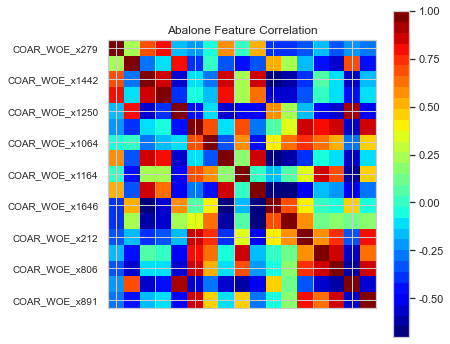

In [62]:
# 相关性剔除后
_, corr_table = func_colinearity_rt_col(
    in_df_features=_df_features,
    corr_threshold=1,
    corr_method="pearson",
)

func_correlation_matrix_hotmap(corr_table, figsize=6)

## 模型训练

In [63]:
####################################################################################
# 过采样处理

# random_seed = random.randint(1, 100000)
# _random = random.randint(25, 30)

# random_seed = 123456
# random_seed = 88888888
random_seed = 26272627
_random = 50
_cols_0 = [s0 for s0 in df_wb_0.columns if s0 not in _cols_modeling_keep_4]

_df_coar_woe = pd.concat([
    df_wb_coar_woe.query("y==1"),
    df_wb_coar_woe.query("y==0"),
#     df_wb_coar_woe.query("flag==0").sample(n=10000, random_state=random_seed),
#     df_wb_coar_woe.query("flag==0").sample(n=20000, random_state=random_seed),
#     df_wb_coar_woe.query("y==0").sample(n=50000, random_state=random_seed),
], ignore_index=True).reset_index(drop=True)


# df_train_widetable_woe_sampling = _df_coar_woe.reset_index(drop=True)

df_train_widetable_woe_sampling = func_oversample_stratify(
    in_df=_df_coar_woe[_cols_0+["COAR_WOE_{}".format(s0) for s0 in list(dict_coarse_bin_mapping_numeric.keys())]] \
                .query("data_role in ['01_train']"),
    n=20000,
#     n=40000,
#     n=100000,
    stratify_key="y",
    group_weight={0: 100-_random, 1: 0+_random},
    random_seed=random_seed,
) \
#     .sample(10000, random_state=random_seed)

print(dict(df_train_widetable_woe_sampling["y"].value_counts(dropna=False)))


{1: 10000, 0: 10000}


In [64]:
_time = time.time()



#######################################################
# 
model_cols_0 = _cols_modeling_keep_4



df_train_X = df_train_widetable_woe_sampling \
    [
        ["COAR_WOE_{}".format(s0) for s0 in model_cols_0] \
#         ["COAR_WOE_{}".format(s0) for s0 in list(dict_coarse_bin_mapping_discrete.keys())+list(dict_coarse_bin_mapping_numeric.keys())] \
#         +[s0 for s0 in df_wb_coar_woe.columns if "OH_BIN_" in s0]
    ].reset_index(drop=True)
df_train_y = df_train_widetable_woe_sampling[["y"]].reset_index(drop=True)

logistic_model_res, model_cols, df_result_selection_step = \
    func_logistic_model_stepwise(
        df_X=df_train_X,
        y=df_train_y.iloc[:, 0],
        method="ncg",
#         initial_cols=None,
#         initial_cols=["COAR_WOE_{}".format(s0) for s0 in model_cols_0],
        include_cols=None,
        exclude_cols=None,
#         sle=0.000001, sls=0.0000001, with_intercept=True, verbose=0,
        sle=0.05, sls=0.01, with_intercept=True, verbose=1,
        max_step=100,
#         max_step=10,
)

# logistic_model_res = func_logistic_model(
#     df_X=df_train_X,
#     y=df_train_y.iloc[:, 0],
#     method="ncg",
#     with_intercept=True,
#     disp=1,
# )
# model_cols = df_train_X.columns.tolist()

t = logistic_model_res.summary2().tables
df_model_summary = t[0]
df_model_params = t[1]

print(time.time()-_time)
print(len(model_cols))

# pd.DataFrame(pd.Series(model_cols).apply(lambda s0: re.sub("^COAR_WOE_", "", s0))).to_clipboard(index=False, header=False)


current step 1:
    variable [ COAR_WOE_x212 ] entered.
    no variable removed.

current step 2:
    variable [ COAR_WOE_x291 ] entered.
    no variable removed.

current step 3:
    variable [ COAR_WOE_x90 ] entered.
    no variable removed.

current step 4:
    variable [ COAR_WOE_x1064 ] entered.
    no variable removed.

current step 5:
    variable [ COAR_WOE_x806 ] entered.
    no variable removed.

current step 6:
    variable [ COAR_WOE_x891 ] entered.
    no variable removed.

current step 7:
    variable [ COAR_WOE_x1646 ] entered.
    no variable removed.

current step 8:
    variable [ COAR_WOE_x256 ] entered.
    variable(s): [ COAR_WOE_x212 ] removed.

current step 10:
    variable [ COAR_WOE_x483 ] entered.
    no variable removed.

current step 11:
    variable [ COAR_WOE_x1659 ] entered.
    no variable removed.

current step 12:
    variable [ COAR_WOE_x1442 ] entered.
    no variable removed.

current step 13:
    variable [ COAR_WOE_x704 ] entered.
    no variable 

In [65]:
_len_cols = len(model_cols)
while 1:
    model_cols = df_model_params[(
        (
            (df_model_params.index!="Intercept") &
            (df_model_params["Coef."]>0) &
            (df_model_params["P>|z|"].notna()) &
            (df_model_params["P>|z|"]<=0.01)
    #         (df_model_params["P>|z|"]<=0.1)
        )
    #     | (df_model_params.index.isin(["COAR_WOE_{}".format(s0) for s0 in model_cols_0]))
    )].index.tolist()
    
    if _len_cols==len(model_cols):
        break
    else:
        _len_cols = len(model_cols)
    
    logistic_model_res = func_logistic_model(
        df_X=df_train_X[model_cols],
        y=df_train_y.iloc[:, 0],
        method="ncg",
        with_intercept=True,
        disp=1,
    )
    t = logistic_model_res.summary2().tables
    df_model_summary = t[0]
    df_model_params = t[1]

print(len(model_cols))
logistic_model_res.summary2()

Optimization terminated successfully.
         Current function value: 0.564902
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 6
Optimization terminated successfully.
         Current function value: 0.565281
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 6
6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.184     
Dependent Variable: y                AIC:              22625.2227
Date:               2021-08-22 02:34 BIC:              22680.5472
No. Observations:   20000            Log-Likelihood:   -11306.   
Df Model:           6                LL-Null:          -13863.   
Df Residuals:       19993            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        -0.3825   0.0180 -21.2650 0.0000 -0.4178 -0.3473
COAR_WOE_x291     0.5215   0.0278  18.7805 0.0000  0.4671  0.5759
COAR_WOE_x90      0.4053   0.0346  11.7039 0.0000  0.3375  0.4732
COAR_WOE_x1064    0.3471   0.0481   7.2194 0.0000  0.2528  0.4413
COAR_WOE_x806     0.3399   0.0264  12.8842 0.0000  0.2882  0.3917
COAR_WOE_x891     0.3958   0.0278  14.2587 0.0000  0.3414  0.4502
COAR_WOE_x256     0.3469   0.0541   6.4103 0.0000  0.2409  0.4530
=================================================================

"""

In [66]:
_, corr_table = func_colinearity_rt_col(
    in_df_features=df_wb_coar_woe[model_cols],
    corr_threshold=0.9,
#     corr_method="kendall",
    corr_method="pearson",
#     corr_method="spearman"
)

func_correlation_matrix_hotmap(df_wb_coar_woe[model_cols], figsize=6)

vif_table = func_multicolinearity_vif(in_df_features=df_wb_coar_woe[model_cols], with_constant=True)
vif_table = vif_table.sort_values(by=["VIF"], ascending=[False]).reset_index(drop=True)
vif_table

feature_name       VIF
0  COAR_WOE_x1064  2.585083
1   COAR_WOE_x256  2.292141
2   COAR_WOE_x291  1.741342
3    COAR_WOE_x90  1.592229
4   COAR_WOE_x806  1.558452
5   COAR_WOE_x891  1.431366

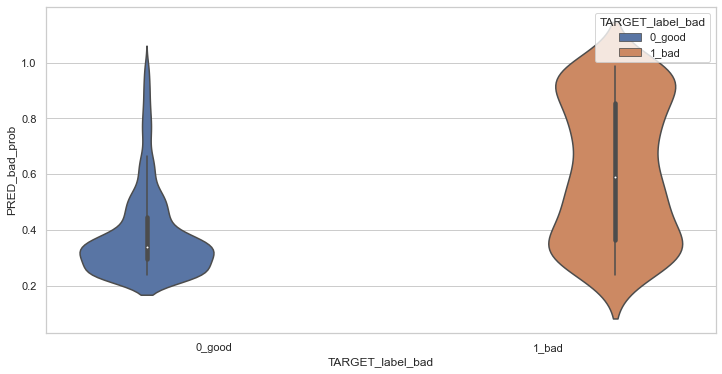

train KS: 0.43582688916022244


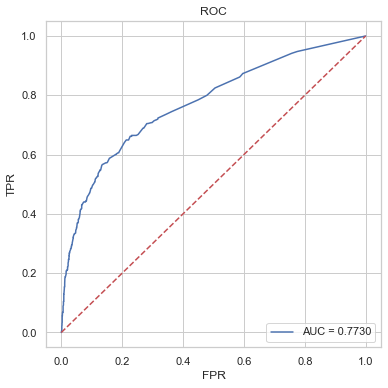

train AUC: 0.7730203952426175


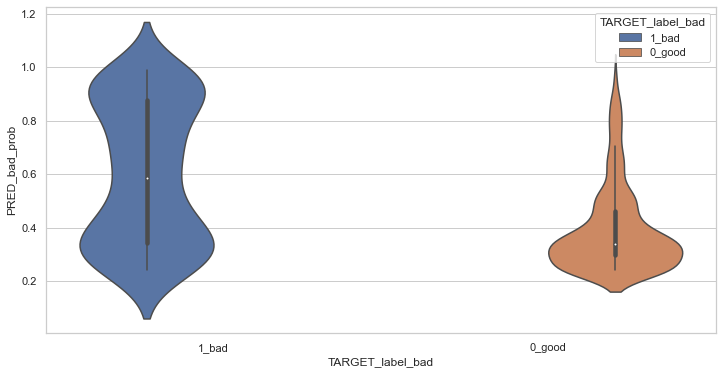

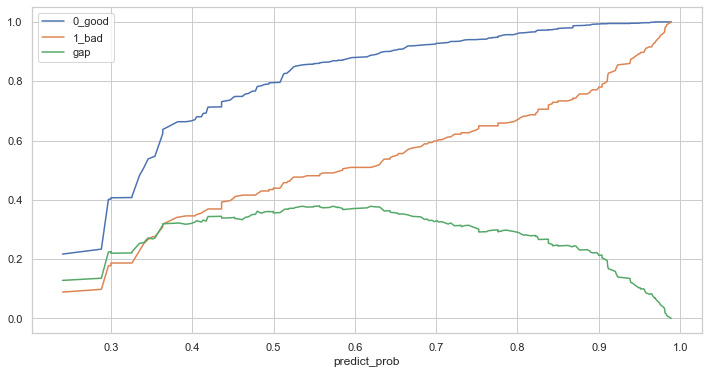

test KS: 0.37985151848627696


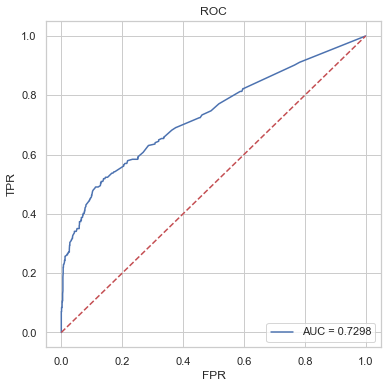

test AUC: 0.7297911568089614


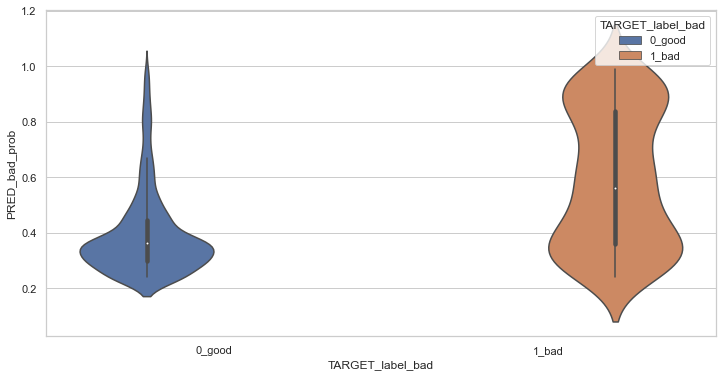

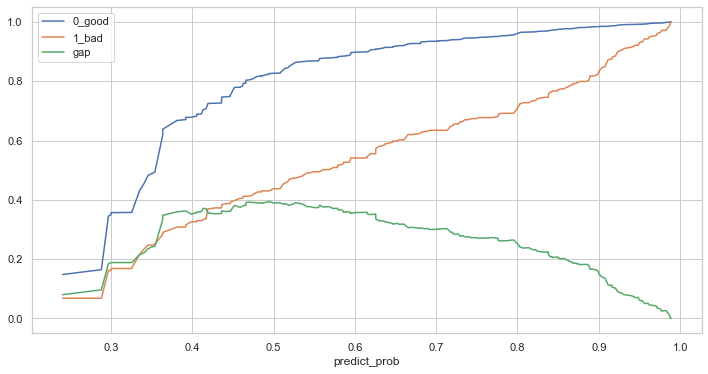

oot KS: 0.39557553322756916


oot AUC: 0.7281440350980278


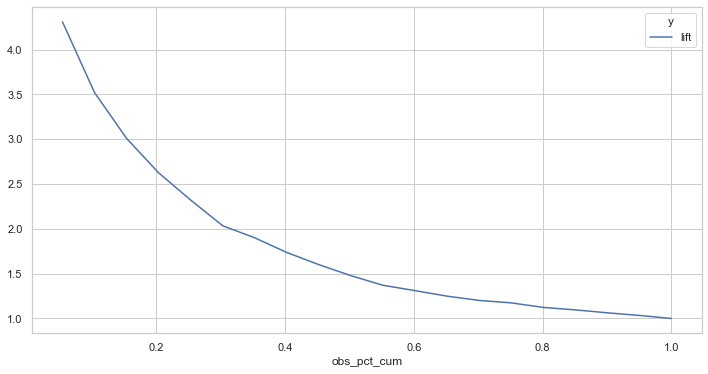

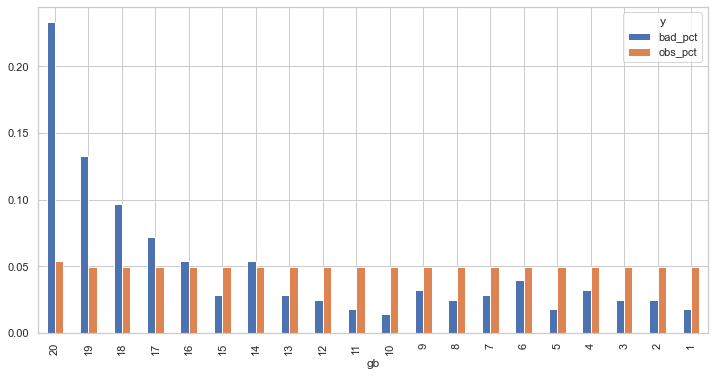

y   gb  bad_cnt  obs_cnt  predict_prob_gte   bad_pct   obs_pct  bad_pct_cum  \
0   20       65      114          0.849589  0.232975  0.054054     0.232975   
1   19       37      105          0.706250  0.132616  0.049787     0.365591   
2   18       27      105          0.594884  0.096774  0.049787     0.462366   
3   17       20      105          0.518459  0.071685  0.049787     0.534050   
4   16       15      105          0.466022  0.053763  0.049787     0.587814   
5   15        8      105          0.436174  0.028674  0.049787     0.616487   
6   14       15      105          0.413444  0.053763  0.049787     0.670251   
7   13        8      105          0.381378  0.028674  0.049787     0.698925   
8   12        7      105          0.363608  0.025090  0.049787     0.724014   
9   11        5      105          0.363608  0.017921  0.049787     0.741935   
10  10        4      105          0.345717  0.014337  0.049787     0.756272   
11   9        9      105          0.335228  0.032258  0.049787     0.788530   
12   8        7      105          0.335228  0.025090  0.049787     0.813620   
13   7        8      105          0.296956  0.028674  0.049787     0.842294   
14   6       11      105          0.296956  0.039427  0.049787     0.881720   
15   5        5      105          0.296956  0.017921  0.049787     0.899642   
16   4        9      105          0.288264  0.032258  0.049787     0.931900   
17   3        7      105          0.240488  0.025090  0.049787     0.956989   
18   2        7      105          0.240488  0.025090  0.049787     0.982079   
19   1        5      105          0.000000  0.017921  0.049787     1.000000   

y   obs_pct_cum      lift  bad_rate  
0      0.054054  4.310036  0.570175  
1      0.103841  3.520695  0.352381  
2      0.153627  3.009658  0.257143  
3      0.203414  2.625435  0.190476  
4      0.253201  2.321534  0.142857  
5      0.302987  2.034698  0.076190  
6      0.352774  1.899945  0.142857  
7      0.402560  1.736198  0.076190  
8      0.452347  1.600573  0.066667  
9      0.502134  1.477566  0.047619  
10     0.551920  1.370256  0.038095  
11     0.601707  1.310489  0.085714  
12     0.651494  1.248854  0.066667  
13     0.701280  1.201080  0.076190  
14     0.751067  1.173957  0.104762  
15     0.800853  1.123354  0.047619  
16     0.850640  1.095528  0.085714  
17     0.900427  1.062817  0.066667  
18     0.950213  1.033535  0.066667  
19     1.000000  1.000000  0.047619

In [67]:
_cols_0 = [s0 for s0 in df_wb_0.columns if s0 not in _cols_feature_n_all]

_df_wb_coar_woe = df_wb_coar_woe \
    [_cols_0+model_cols] \
    .reset_index(drop=True)

# train
df_train_result = _df_wb_coar_woe.query("data_role in ['01_train']") \
    .reset_index(drop=True)
df_train_result["predict"] = logistic_model_res.predict(
    exog=sm.add_constant(df_train_result[model_cols], has_constant="add")
).values

# train
ks, crossdens = func_calc_ks_cross(
    y_labels=df_train_result["y"].apply(lambda s0: ("0_good" if s0==0 else "1_bad")),
    y_pred=df_train_result["predict"],
    plot=True,
)
print("train KS: {}".format(ks["gap"].max()))

auc = func_calc_auc_roc(
    y_labels=df_train_result["y"],
    y_pred=df_train_result["predict"],
    plot=True,
)
print("train AUC: {}".format(auc))

# test
df_test_result = _df_wb_coar_woe.query("data_role in ['02_test']") \
    .reset_index(drop=True)
df_test_result["predict"] = logistic_model_res.predict(
    exog=sm.add_constant(df_test_result[model_cols], has_constant="add")
).values

# test
ks, crossdens = func_calc_ks_cross(
    y_labels=df_test_result["y"].apply(lambda s0: ("0_good" if s0==0 else "1_bad")),
    y_pred=df_test_result["predict"],
    plot=True,
)
print("test KS: {}".format(ks["gap"].max()))

auc = func_calc_auc_roc(
    y_labels=df_test_result["y"],
    y_pred=df_test_result["predict"],
    plot=True,
)
print("test AUC: {}".format(auc))

# oot
df_oot_result = _df_wb_coar_woe.query("data_role in ['03_oot']") \
    .reset_index(drop=True)
df_oot_result["predict"] = logistic_model_res.predict(
    exog=sm.add_constant(df_oot_result[model_cols], has_constant="add")
).values

# oot
ks, crossdens = func_calc_ks_cross(
    y_labels=df_oot_result["y"].apply(lambda s0: ("0_good" if s0==0 else "1_bad")),
    y_pred=df_oot_result["predict"],
    plot=True,
)
print("oot KS: {}".format(ks["gap"].max()))

auc = func_calc_auc_roc(
    y_labels=df_oot_result["y"],
    y_pred=df_oot_result["predict"],
    plot=True,
)
print("oot AUC: {}".format(auc))


# # lift
# crosstab = func_calc_lift(
#     y_labels=pd.concat([df_train_result, df_test_result, df_oot_result], ignore_index=True)["y"],
#     y_pred=pd.concat([df_train_result, df_test_result, df_oot_result], ignore_index=True)["predict"],
#     bucket_cnt=20, bad_label=1, plot=True,
# )

# crosstab.to_clipboard(index=False)
# crosstab

# lift
crosstab = func_calc_lift(
    y_labels=pd.concat([df_oot_result], ignore_index=True)["y"],
    y_pred=pd.concat([df_oot_result], ignore_index=True)["predict"],
    bucket_cnt=20, bad_label=1, plot=True,
)

crosstab.to_clipboard(index=False)
crosstab

## 输出结果

In [86]:
# #########################################################
# res_excel_writer_p3 = pd.ExcelWriter(r"{}/res_题目三.xlsx".format(output_path))

# #########################################################
# df_t_describe_summary.to_excel(
#     res_excel_writer_p3, index=False, sheet_name="1_特征变量的描述性统计分析",
# )

# #########################################################
# _df_gb_apply_time_YM.to_excel(
#     res_excel_writer_p3, index=False, sheet_name="2_申请月份的统计信息",
# )


# #########################################################
# df_t_features_fine_iv_eq10.drop(labels=["crosstab_converted"], axis=1).to_excel(
#     res_excel_writer_p3, index=False, sheet_name="3_数值型特征_等频分箱汇总结果（最大10等份）",
# )
# df_t_features_fine_iv_ew05.drop(labels=["crosstab_converted"], axis=1).to_excel(
#     res_excel_writer_p3, index=False, sheet_name="3_数值型特征_等距分箱汇总结果（最大5箱）",
# )

# #########################################################
# df_t_features_fine_woe_report_eq10.to_excel(
#     res_excel_writer_p3, index=False, sheet_name="3_数值型特征_等频分箱WOE报告（最大10等份）",
# )
# df_t_features_fine_woe_report_ew05.to_excel(
#     res_excel_writer_p3, index=False, sheet_name="3_数值型特征_等距分箱WOE报告（最大5箱）",
# )

# #########################################################
# df_t_features_coar_woe_report \
#     [df_t_features_coar_woe_report["feature_name"].isin([re.sub("^COAR_WOE_", "", s0) for s0 in model_cols])] \
#     .to_excel(
#         res_excel_writer_p3, index=False, sheet_name="4_入模指标分箱报告",
#     )

# df_model_params.to_excel(
#     res_excel_writer_p3, index=True, sheet_name="4_模型训练参数",
# )

# #########################################################
# res_excel_writer_p3.save()
# res_excel_writer_p3.close()


# 题目四

## 对树深度进行遍历。

In [1]:
# 二叉树定义
class Node(object):
    def __init__(self, value):
        self.value = value
        self.parent = None
        self.left = None
        self.right = None
    
class Queue(object):
    def __init__(self):
        self.ser_list = list()
        
    def check_if_empty(self):
        return (len(self.ser_list)==0)
    
    def enter(self, value):
        self.ser_list.insert(0, value)
    
    def outer(self):
        if self.check_if_empty():
            return None
        else:
            return self.ser_list.pop()
    
class BinaryTree(Node):
    def __init__(self, tree_root=None):
        self.tree_root = None
    
    def check_if_empty(self):
        return (self.tree_root is None)
    
    def append_node(self, value):
        node = Node(value=value)
        
        if self.check_if_empty():
            self.tree_root = node
            return None
        
        else:
            queue = Queue()
            queue.enter(self.tree_root)
            while not queue.check_if_empty():
                curr = queue.outer()
                if curr.left is None:
                    curr.left = node
                    node.parent = curr
                    return None
                else:
                    queue.enter(curr.left)
                    
                if curr.right is None:
                    curr.right = node
                    node.parent = curr
                    return None
                else:
                    queue.enter(curr.right)
    
    def show(self):
        if self.check_if_empty():
            print("Empty Tree.")
        else:
            queue = Queue()
            queue.enter(self.tree_root)
            while not queue.check_if_empty():
                curr = queue.outer()
                print(curr.value, end=" > ")
                if curr.left is not None:
                    queue.enter(curr.left)
                if curr.right is not None:
                    queue.enter(curr.right)
    
    # 先序遍历
    def preorder_traversal(self, curr_node):
        if curr_node is None:
            pass
        else:
            print(curr_node.value, end=" > ")
            self.preorder_traversal(curr_node=curr_node.left)
            self.preorder_traversal(curr_node=curr_node.right)
    
    # 中序遍历
    def inorder_traversal(self, curr_node):
        if curr_node is None:
            pass
        else:
            self.inorder_traversal(curr_node=curr_node.left)
            print(curr_node.value, end=" > ")
            self.inorder_traversal(curr_node=curr_node.right)
    
    # 后序遍历
    def postorder_traversal(self, curr_node):
        if curr_node is None:
            pass
        else:
            self.postorder_traversal(curr_node=curr_node.left)
            self.postorder_traversal(curr_node=curr_node.right)
            print(curr_node.value, end=" > ")
    

In [28]:
tree = BinaryTree()
for value in range(20):
    tree.append_node(value=value)

In [33]:
print("广度最优遍历的二叉树结构：")
tree.show()

广度最优遍历的二叉树结构：
0 > 1 > 2 > 3 > 4 > 5 > 6 > 7 > 8 > 9 > 10 > 11 > 12 > 13 > 14 > 15 > 16 > 17 > 18 > 19 > 

In [34]:
print("先序遍历的深度最优遍历结果：")
tree.preorder_traversal(curr_node=tree.tree_root)

先序遍历的深度最优遍历结果：
0 > 1 > 3 > 7 > 15 > 16 > 8 > 17 > 18 > 4 > 9 > 19 > 10 > 2 > 5 > 11 > 12 > 6 > 13 > 14 > 

In [35]:
print("中序遍历的深度最优遍历结果：")
tree.inorder_traversal(curr_node=tree.tree_root)

中序遍历的深度最优遍历结果：
15 > 7 > 16 > 3 > 17 > 8 > 18 > 1 > 19 > 9 > 4 > 10 > 0 > 11 > 5 > 12 > 2 > 13 > 6 > 14 > 

In [36]:
print("后序遍历的深度最优遍历结果：")
tree.postorder_traversal(curr_node=tree.tree_root)

后序遍历的深度最优遍历结果：
15 > 16 > 7 > 17 > 18 > 8 > 3 > 19 > 9 > 10 > 4 > 1 > 11 > 12 > 5 > 13 > 14 > 6 > 2 > 0 > 